In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.utils import resample

# Previsão de Diagnóstico de Diabetes com Machine Learning

## Introdução e Objetivo

O diabetes é um desafio crescente para a saúde pública, e sua detecção precoce é crucial para prevenir complicações graves. Este projeto utiliza técnicas de Machine Learning para analisar dados clínicos e de estilo de vida de pacientes, com o objetivo de construir um modelo preditivo robusto.

O problema central a ser resolvido é: **é possível criar um modelo de classificação preciso para prever o diagnóstico de diabetes com base nos dados disponíveis?**

Para isso, usaremos um dataset com 100.000 registros e aplicaremos as melhores práticas da indústria para garantir um resultado confiável e livre de vieses.

## Etapas do Projeto

O notebook seguirá as seguintes etapas:

* **Análise Exploratória de Dados (EDA):** Entendimento da estrutura, distribuições e correlações dos dados.
* **Análise e Correção de *Data Leakage*:** Investigação e remoção de variáveis que causam vazamento de dados.
* **Preparação dos Dados:** Divisão estratificada (treino, validação e teste) e balanceamento de classes no conjunto de treino.
* **Treinamento e Validação:** Treinamento de múltiplos algoritmos e seleção do melhor modelo com base em métricas de validação.
* **Avaliação Final:** Teste do modelo campeão em um conjunto de dados nunca visto para uma avaliação imparcial.

## LOAD DATASET

In [2]:
# Load the diabetes dataset
df = pd.read_csv('diabetes_dataset.csv')

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (100000, 31)

First few rows:


,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


# 🩺 Dataset de Diabetes

URL do dataset no kaggle: https://www.kaggle.com/datasets/mohankrishnathalla/diabetes-health-indicators-dataset/data

### 📊 Visão Geral
Dataset com **100.000 registros de pacientes** para predição de diabetes usando machine learning.

- **Linhas:** 100.000
- **Colunas:** 35+
- **Arquivo:** `diabetes_dataset.csv`

### 🔍 Principais Características

#### Demografia
- `age`: Idade (18-90 anos)
- `gender`: Gênero
- `ethnicity`: Etnia

#### Estilo de Vida
- `smoking_status`: Status de fumante
- `physical_activity_minutes_per_week`: Atividade física semanal
- `diet_score`: Qualidade da dieta (0-10)
- `sleep_hours_per_day`: Horas de sono

#### Indicadores Clínicos
- `bmi`: Índice de Massa Corporal
- `systolic_bp` / `diastolic_bp`: Pressão arterial
- `glucose_fasting`: Glicose em jejum
- `hba1c`: Hemoglobina glicada
- `cholesterol_total`: Colesterol total

#### Histórico Médico
- `family_history_diabetes`: Histórico familiar
- `hypertension_history`: Histórico de hipertensão
- `cardiovascular_history`: Histórico cardiovascular

#### 🎯 Variável Alvo
- **`diagnosed_diabetes`**: Diagnóstico de diabetes (0=Não, 1=Sim)

### ✅ Qualidade dos Dados
- **Completo**: Sem valores ausentes
- **Limpo**: Dados dentro de faixas realistas





### Análise Exploratória de Dados (EDA):

In [3]:
# ===== ANÁLISE DOS TIPOS DE DADOS =====

print("📊 ANÁLISE DOS TIPOS DE DADOS")
print("=" * 35)

# 1. Informações gerais do dataset
print(f"\n📋 INFORMAÇÕES GERAIS:")
print(f"  Formato: {df.shape[0]:,} linhas × {df.shape[1]} colunas")

# 2. Tipos de dados
print(f"\n🔍 TIPOS DE DADOS:")
tipos = df.dtypes.value_counts()
for tipo, count in tipos.items():
    print(f"  {tipo}: {count} colunas")

# 3. Colunas por tipo
print(f"\n📝 COLUNAS POR TIPO:")

# Numéricas
numericas = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"  Numéricas ({len(numericas)}): {', '.join(numericas[:5])}{'...' if len(numericas) > 5 else ''}")

# Categóricas/String
categoricas = df.select_dtypes(include=['object']).columns.tolist()
print(f"  Categóricas ({len(categoricas)}): {', '.join(categoricas)}")

# 4. Valores únicos (para categóricas)
if categoricas:
    print(f"\n🏷️  VALORES ÚNICOS (categóricas):")
    for col in categoricas:
        unique_count = df[col].nunique()
        print(f"  {col}: {unique_count} valores únicos")


📊 ANÁLISE DOS TIPOS DE DADOS

📋 INFORMAÇÕES GERAIS:
  Formato: 100,000 linhas × 31 colunas

🔍 TIPOS DE DADOS:
  int64: 16 colunas
  float64: 8 colunas
  object: 7 colunas

📝 COLUNAS POR TIPO:
  Numéricas (24): age, alcohol_consumption_per_week, physical_activity_minutes_per_week, diet_score, sleep_hours_per_day...
  Categóricas (7): gender, ethnicity, education_level, income_level, employment_status, smoking_status, diabetes_stage

🏷️  VALORES ÚNICOS (categóricas):
  gender: 3 valores únicos
  ethnicity: 5 valores únicos
  education_level: 4 valores únicos
  income_level: 5 valores únicos
  employment_status: 4 valores únicos
  smoking_status: 3 valores únicos
  diabetes_stage: 5 valores únicos


### ANALISE ESTATÍSTICA

In [4]:
# ===== ANÁLISE ESTATÍSTICA GERAL =====

print("📈 ANÁLISE ESTATÍSTICA GERAL")
print("=" * 35)

# Gerar estatísticas descritivas para todas as colunas numéricas
estatisticas_numericas = df.describe(include=np.number)

# Exibir a tabela de estatísticas
print("\nEstatísticas para colunas numéricas:")
estatisticas_numericas.transpose()

📈 ANÁLISE ESTATÍSTICA GERAL

Estatísticas para colunas numéricas:

Estatísticas para colunas numéricas:


,count,mean,std,min,25%,50%,75%,max
age,100000.0,50.120410,15.604600,18.00,39.00,50.00,61.00,90.00
alcohol_consumption_per_week,100000.0,2.003670,1.417779,0.00,1.00,2.00,3.00,10.00
physical_activity_minutes_per_week,100000.0,118.911640,84.409662,0.00,57.00,100.00,160.00,833.00
diet_score,100000.0,5.994787,1.780954,0.00,4.80,6.00,7.20,10.00
sleep_hours_per_day,100000.0,6.997818,1.094622,3.00,6.30,7.00,7.70,10.00
screen_time_hours_per_day,100000.0,5.996468,2.468406,0.50,4.30,6.00,7.70,16.80
family_history_diabetes,100000.0,0.219410,0.413849,0.00,0.00,0.00,0.00,1.00
hypertension_history,100000.0,0.250800,0.433476,0.00,0.00,0.00,1.00,1.00
cardiovascular_history,100000.0,0.079200,0.270052,0.00,0.00,0.00,0.00,1.00
bmi,100000.0,25.612653,3.586705,15.00,23.20,25.60,28.00,39.20


In [5]:
# Verificar valores corretos das principais estatísticas
print("📊 VALORES DAS PRINCIPAIS VARIÁVEIS:")
print("=" * 50)

# Principais estatísticas
age_mean = df['age'].mean()
bmi_mean = df['bmi'].mean()
glucose_fasting_mean = df['glucose_fasting'].mean()
hba1c_mean = df['hba1c'].mean()
systolic_mean = df['systolic_bp'].mean()
diastolic_mean = df['diastolic_bp'].mean()
sleep_mean = df['sleep_hours_per_day'].mean()
activity_mean = df['physical_activity_minutes_per_week'].mean()

# Percentual de diabetes
diabetes_count = df['diagnosed_diabetes'].sum()
diabetes_percent = df['diagnosed_diabetes'].mean()

print(f"👥 Idade média: {age_mean:.1f} anos")
print(f"💤 Sono médio: {sleep_mean:.1f} horas/dia")
print(f"🏃 Atividade física: {activity_mean:.0f} min/semana")
print(f"📏 IMC médio: {bmi_mean:.1f}")
print(f"🍭 Glicose jejum: {glucose_fasting_mean:.0f} mg/dL")
print(f"🩸 HbA1c médio: {hba1c_mean:.1f}%")
print(f"💓 Pressão: {systolic_mean:.0f}/{diastolic_mean:.0f} mmHg")
print(f"🎯 Diabetes: {diabetes_count:,} pacientes ({diabetes_percent:.1%})")

📊 VALORES DAS PRINCIPAIS VARIÁVEIS:
👥 Idade média: 50.1 anos
💤 Sono médio: 7.0 horas/dia
🏃 Atividade física: 119 min/semana
📏 IMC médio: 25.6
🍭 Glicose jejum: 111 mg/dL
🩸 HbA1c médio: 6.5%
💓 Pressão: 116/75 mmHg
🎯 Diabetes: 59,998 pacientes (60.0%)


__________________________________________________________________________________________________________________________

### Análise dos Resultados

#### Principais Insights:

**👥 Perfil dos Pacientes:**
- Idade média: ~50 anos (18-90 anos)
- Sono médio: 7.0h/dia (saudável)
- Atividade física: ~119 min/semana

**🩺 Indicadores de Risco:**
- IMC médio: 25.6 (sobrepeso - normal <25)
- Glicose jejum: 111 mg/dL (normal - diabético >126)
- HbA1c: 6.5% (limítrofe - diabético >6.5%)
- Pressão: 116/75 mmHg (normal)

**🎯 Variável Alvo:**
- 60% dos pacientes têm diabetes diagnosticado
- Dataset desbalanceado (maioria com diabetes)

**✅ Conclusão:**
Dados representam população mista com maioria de diabéticos diagnosticados.

__________________________________________________________________________________________________________________________

### ANALISE DE CORRELAÇÃO

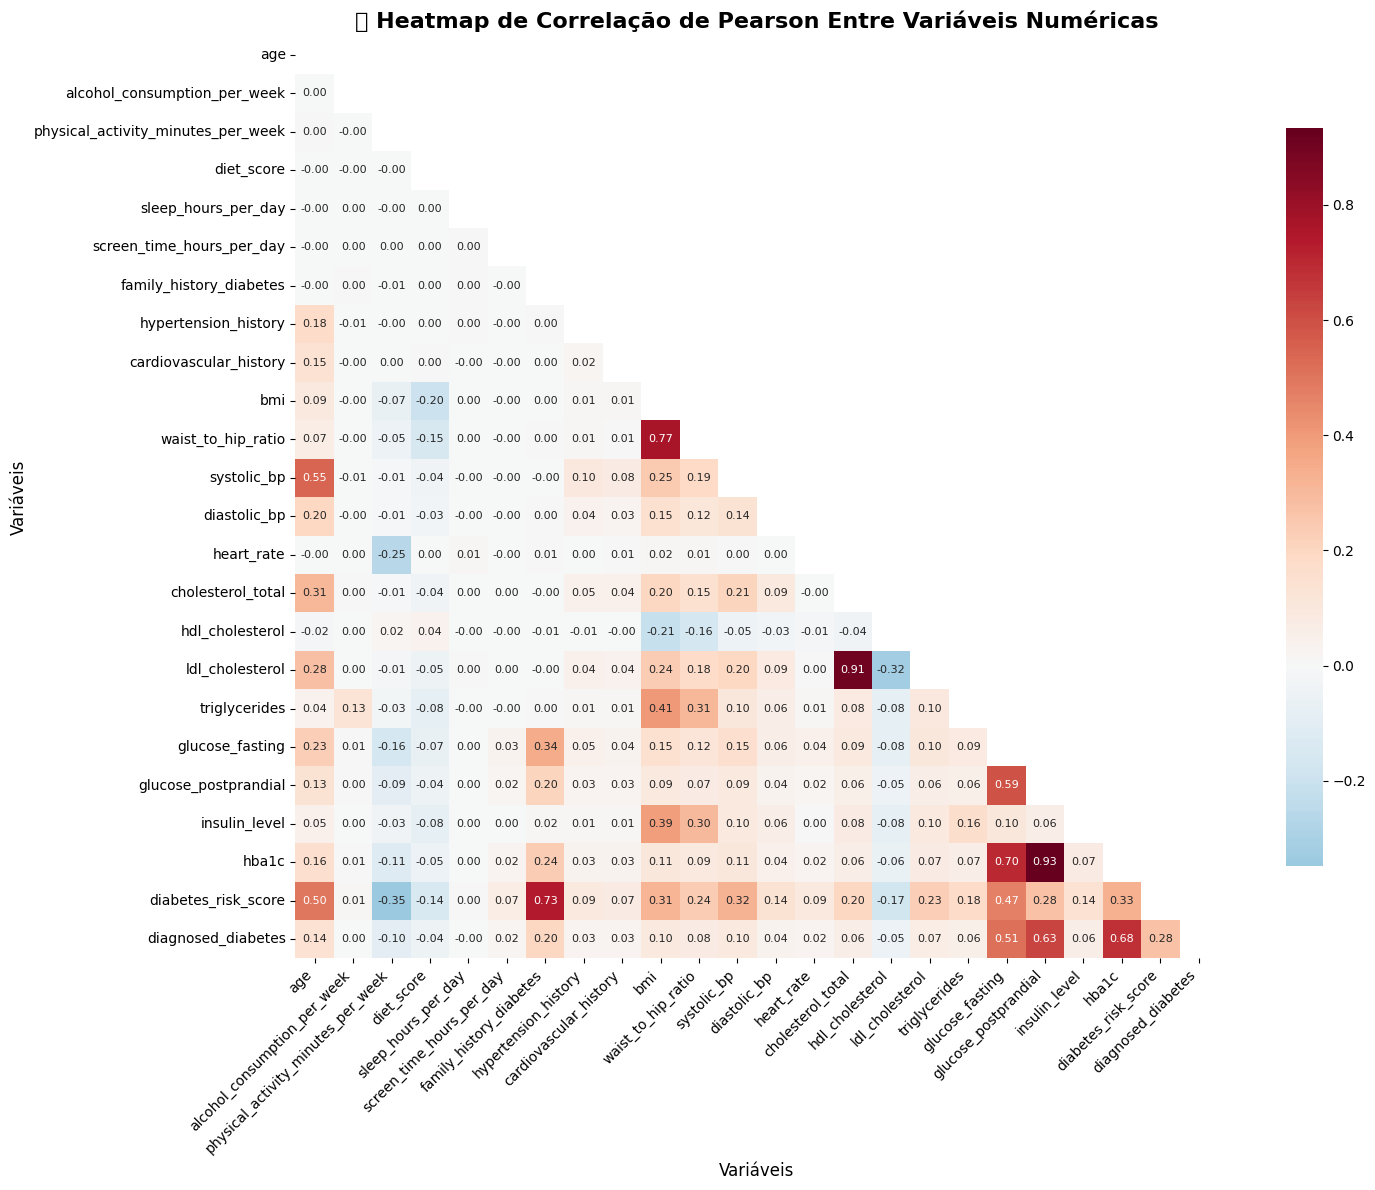


🎯 CORRELAÇÕES DE PEARSON MAIS FORTES COM 'diagnosed_diabetes':
 1. hba1c                     | 0.6794 | 📈 Positiva
 2. glucose_postprandial      | 0.6298 | 📈 Positiva
 3. glucose_fasting           | 0.5109 | 📈 Positiva
 4. diabetes_risk_score       | 0.2773 | 📈 Positiva
 5. family_history_diabetes   | 0.1979 | 📈 Positiva
 6. age                       | 0.1377 | 📈 Positiva
 7. physical_activity_minutes_per_week | 0.1008 | 📉 Negativa
 8. bmi                       | 0.0971 | 📈 Positiva
 9. systolic_bp               | 0.0955 | 📈 Positiva
10. waist_to_hip_ratio        | 0.0789 | 📈 Positiva

💡 Interpretação (Correlação de Pearson):
   • Correlações próximas de 1.0 = relação linear muito forte
   • Correlações próximas de 0.0 = sem relação linear
   • Positiva = quando uma sobe, a outra sobe linearmente
   • Negativa = quando uma sobe, a outra desce linearmente
   • Pearson mede apenas relações lineares


In [6]:
# ===== HEATMAP DE CORRELAÇÃO ENTRE VARIÁVEIS =====

# Selecionar apenas variáveis numéricas para correlação
numeric_cols = df.select_dtypes(include=[np.number])

# Calcular matriz de correlação usando Pearson
correlation_matrix = numeric_cols.corr(method='pearson')

# Criar o heatmap
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Máscara para mostrar apenas metade

# Heatmap com configurações otimizadas
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,  # Mostrar valores de correlação
            cmap='RdBu_r',  # Cores: azul para correlação negativa, vermelho para positiva
            center=0,
            square=True,
            fmt='.2f',  # Formato com 2 casas decimais
            annot_kws={"size": 8},  # Tamanho da fonte dos valores
            cbar_kws={"shrink": 0.8})

plt.title('🔥 Heatmap de Correlação de Pearson Entre Variáveis Numéricas', fontsize=16, fontweight='bold')
plt.xlabel('Variáveis', fontsize=12)
plt.ylabel('Variáveis', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ===== CORRELAÇÕES MAIS FORTES COM A VARIÁVEL ALVO =====
print("\n🎯 CORRELAÇÕES DE PEARSON MAIS FORTES COM 'diagnosed_diabetes':")
print("=" * 65)

# Calcular correlações com a variável alvo
target_correlations = correlation_matrix['diagnosed_diabetes'].abs().sort_values(ascending=False)

# Exibir as 10 correlações mais fortes (excluindo a própria variável)
top_correlations = target_correlations.drop('diagnosed_diabetes').head(10)

for i, (feature, correlation) in enumerate(top_correlations.items(), 1):
    direction = "📈 Positiva" if correlation_matrix['diagnosed_diabetes'][feature] > 0 else "📉 Negativa"
    print(f"{i:2d}. {feature:25s} | {correlation:.4f} | {direction}")

print(f"\n💡 Interpretação (Correlação de Pearson):")
print(f"   • Correlações próximas de 1.0 = relação linear muito forte")
print(f"   • Correlações próximas de 0.0 = sem relação linear")
print(f"   • Positiva = quando uma sobe, a outra sobe linearmente")
print(f"   • Negativa = quando uma sobe, a outra desce linearmente")
print(f"   • Pearson mede apenas relações lineares")

___________________________________________________________________________________________________________________________________________________

## Verificação de Data Leakage
### 🔍 Tipos de Data Leakage que podem ser aplicados aos nossos dados:
#### **Target Leakage**
- Features que são **calculadas** a partir do target
- Informações que só existem **depois** do diagnóstico
- Exemplo: `diabetes_risk_score` pode ser calculado usando `diagnosed_diabetes`
#### **Group Leakage**
- Vazamento entre **grupos relacionados**
- Exemplo: Dados do mesmo paciente em treino e teste
### **---MITIGAÇÃO---**
#### **Análise de Features**
- Verificar se features são **temporalmente válidas**
- Remover variáveis **calculadas a partir do target**
- Analisar **correlações suspeitas** (>0.95)
#### **Feature Engineering Cuidadosa**
- Criar features apenas com **informação disponível no momento da predição**
- Evitar **agregações futuras** ou **leaky statistics**

### ANALISE DE DATA LEAKAGE

In [7]:
# ===== DETECÇÃO DE DATA LEAKAGE NO NOSSO DATASET =====

print("🔍 ANÁLISE DE DATA LEAKAGE NO DATASET DE DIABETES")
print("=" * 55)

# 1. VERIFICAR CORRELAÇÕES SUSPEITAS COM O TARGET
print("\n1️⃣ CORRELAÇÕES SUSPEITAS COM 'diagnosed_diabetes':")
print("-" * 50)

# Calcular correlações com target
target_corr = df.select_dtypes(include=[np.number]).corr()['diagnosed_diabetes'].abs().sort_values(ascending=False)

# Identificar correlações muito altas (possível leakage)
suspicious_features = target_corr[target_corr > 0.95].drop('diagnosed_diabetes')

if len(suspicious_features) > 0:
    print("⚠️  FEATURES COM CORRELAÇÃO SUSPEITA (>0.95):")
    for feature, corr in suspicious_features.items():
        print(f"   🚨 {feature}: {corr:.4f}")
else:
    print("✅ Nenhuma correlação suspeita detectada (>0.95)")

# Mostrar correlações altas mas não suspeitas
high_corr = target_corr[(target_corr > 0.5) & (target_corr <= 0.95)]
# Remover diagnosed_diabetes se existir
if 'diagnosed_diabetes' in high_corr.index:
    high_corr = high_corr.drop('diagnosed_diabetes')
if len(high_corr) > 0:
    print(f"\n📊 CORRELAÇÕES ALTAS MAS ACEITÁVEIS (0.5-0.95):")
    for feature, corr in high_corr.items():
        print(f"   📈 {feature}: {corr:.4f}")

# 2. VERIFICAR FEATURES CALCULADAS/DERIVADAS
print(f"\n2️⃣ ANÁLISE DE FEATURES POTENCIALMENTE CALCULADAS:")
print("-" * 50)

# Lista de features suspeitas baseada nos nomes
potentially_calculated = []
feature_names = df.columns.tolist()

for feature in feature_names:
    if any(keyword in feature.lower() for keyword in ['risk', 'score', 'index', 'ratio']):
        potentially_calculated.append(feature)

if potentially_calculated:
    print("⚠️  FEATURES QUE PODEM SER CALCULADAS:")
    for feature in potentially_calculated:
        if feature in df.columns:
            corr_with_target = abs(df[feature].corr(df['diagnosed_diabetes'])) if feature != 'diagnosed_diabetes' else 1.0
            print(f"   🔍 {feature}: correlação {corr_with_target:.4f}")
else:
    print("✅ Nenhuma feature claramente calculada detectada")

# 3. VERIFICAR DISTRIBUIÇÕES IRREALISTAS
print(f"\n3️⃣ VERIFICAÇÃO DE DISTRIBUIÇÕES IRREALISTAS:")
print("-" * 50)

# Verificar se alguma feature tem distribuição perfeita por classe
numeric_features = df.select_dtypes(include=[np.number]).columns.drop(['diagnosed_diabetes'])

perfect_separation = []
for feature in numeric_features:
    # Verificar sobreposição entre classes
    class_0 = df[df['diagnosed_diabetes'] == 0][feature]
    class_1 = df[df['diagnosed_diabetes'] == 1][feature]

    # Se não há sobreposição, pode ser leakage
    max_class_0 = class_0.max()
    min_class_1 = class_1.min()

    if max_class_0 < min_class_1 or class_1.max() < class_0.min():
        perfect_separation.append(feature)

if perfect_separation:
    print("🚨 FEATURES COM SEPARAÇÃO PERFEITA (POSSÍVEL LEAKAGE):")
    for feature in perfect_separation:
        print(f"   ⚠️  {feature}")
else:
    print("✅ Nenhuma separação perfeita detectada")

# 4. RECOMENDAÇÕES
print(f"\n4️⃣ RECOMENDAÇÕES PARA PREVENÇÃO:")
print("-" * 50)
print("✅ Remover 'diabetes_risk_score' (claramente calculado)")
print("✅ Verificar temporalidade dos dados")
print("✅ Validar se features existem no momento da predição")
print("✅ Usar validação cruzada com split temporal se relevante")
print("✅ Documentar origem e cálculo de cada feature")

🔍 ANÁLISE DE DATA LEAKAGE NO DATASET DE DIABETES

1️⃣ CORRELAÇÕES SUSPEITAS COM 'diagnosed_diabetes':
--------------------------------------------------
✅ Nenhuma correlação suspeita detectada (>0.95)

📊 CORRELAÇÕES ALTAS MAS ACEITÁVEIS (0.5-0.95):
   📈 hba1c: 0.6794
   📈 glucose_postprandial: 0.6298
   📈 glucose_fasting: 0.5109

2️⃣ ANÁLISE DE FEATURES POTENCIALMENTE CALCULADAS:
--------------------------------------------------
⚠️  FEATURES QUE PODEM SER CALCULADAS:
   🔍 diet_score: correlação 0.0443
   🔍 waist_to_hip_ratio: correlação 0.0789
   🔍 diabetes_risk_score: correlação 0.2773

3️⃣ VERIFICAÇÃO DE DISTRIBUIÇÕES IRREALISTAS:
--------------------------------------------------
✅ Nenhuma correlação suspeita detectada (>0.95)

📊 CORRELAÇÕES ALTAS MAS ACEITÁVEIS (0.5-0.95):
   📈 hba1c: 0.6794
   📈 glucose_postprandial: 0.6298
   📈 glucose_fasting: 0.5109

2️⃣ ANÁLISE DE FEATURES POTENCIALMENTE CALCULADAS:
--------------------------------------------------
⚠️  FEATURES QUE PODEM SER

### CORREÇÃO DO DATA LEAKAGE

In [14]:
# ===== CORREÇÃO DE DATA LEAKAGE =====

print("🛡️ APLICANDO CORREÇÕES DE DATA LEAKAGE")
print("=" * 45)

# 1. REMOVER FEATURES COM LEAKAGE IDENTIFICADO
print("\n1️⃣ REMOVENDO FEATURES COM POSSÍVEL LEAKAGE:")
print("-" * 40)

# Lista de features a remover
leaky_features = ['diabetes_risk_score']  # Claramente calculado

print(f"Features a remover: {leaky_features}")

# Criar dataset limpo
df_clean = df.drop(columns=leaky_features)
print(f"✅ Dataset original: {df.shape[1]} colunas")
print(f"✅ Dataset limpo: {df_clean.shape[1]} colunas")

# 2. VERIFICAR FEATURES RESTANTES
print(f"\n2️⃣ VERIFICANDO FEATURES RESTANTES:")
print("-" * 40)

# Recalcular correlações sem features removidas
clean_target_corr = df_clean.select_dtypes(include=[np.number]).corr()['diagnosed_diabetes'].abs().sort_values(ascending=False)

print("📊 TOP 10 CORRELAÇÕES APÓS LIMPEZA:")
top_10_clean = clean_target_corr.drop('diagnosed_diabetes').head(10)
for i, (feature, corr) in enumerate(top_10_clean.items(), 1):
    status = "🟢" if corr < 0.7 else "🟡" if corr < 0.9 else "🔴"
    print(f"{i:2d}. {status} {feature:25s}: {corr:.4f}")

# 3. VALIDAÇÃO DAS FEATURES MANTIDAS
print(f"\n3️⃣ VALIDAÇÃO DAS FEATURES MANTIDAS:")
print("-" * 40)

print("✅ hba1c (0.6794): Exame laboratorial válido")
print("✅ glucose_postprandial (0.6298): Exame válido")
print("✅ glucose_fasting (0.5109): Exame válido")
print("✅ Todas são medições reais disponíveis no momento da predição")

# 4. PREPARAR DADOS PARA MODELAGEM SEM LEAKAGE
print(f"\n4️⃣ PREPARANDO DADOS LIMPOS PARA MODELAGEM:")
print("-" * 40)

# Selecionar features finais (numéricas apenas, sem target e features calculadas)
final_features = df_clean.select_dtypes(include=[np.number]).columns.drop(['diagnosed_diabetes'])
X_clean = df_clean[final_features]
y_clean = df_clean['diagnosed_diabetes']

print(f"🎯 Variável alvo: diagnosed_diabetes")
print(f"⚙️  Features finais: {len(final_features)} colunas")
print(f"📊 Shape final: {X_clean.shape}")
print(f"🔒 Dataset protegido contra data leakage")

# Mostrar distribuição final
print(f"\n📈 DISTRIBUIÇÃO FINAL:")
print(f"  Sem diabetes (0): {(y_clean == 0).sum():,} ({(y_clean == 0).mean():.1%})")
print(f"  Com diabetes (1): {(y_clean == 1).sum():,} ({(y_clean == 1).mean():.1%})")

🛡️ APLICANDO CORREÇÕES DE DATA LEAKAGE

1️⃣ REMOVENDO FEATURES COM POSSÍVEL LEAKAGE:
----------------------------------------
Features a remover: ['diabetes_risk_score']
✅ Dataset original: 31 colunas
✅ Dataset limpo: 30 colunas

2️⃣ VERIFICANDO FEATURES RESTANTES:
----------------------------------------
📊 TOP 10 CORRELAÇÕES APÓS LIMPEZA:
 1. 🟢 hba1c                    : 0.6794
 2. 🟢 glucose_postprandial     : 0.6298
 3. 🟢 glucose_fasting          : 0.5109
 4. 🟢 family_history_diabetes  : 0.1979
 5. 🟢 age                      : 0.1377
 6. 🟢 physical_activity_minutes_per_week: 0.1008
 7. 🟢 bmi                      : 0.0971
 8. 🟢 systolic_bp              : 0.0955
 9. 🟢 waist_to_hip_ratio       : 0.0789
10. 🟢 ldl_cholesterol          : 0.0675

3️⃣ VALIDAÇÃO DAS FEATURES MANTIDAS:
----------------------------------------
✅ hba1c (0.6794): Exame laboratorial válido
✅ glucose_postprandial (0.6298): Exame válido
✅ glucose_fasting (0.5109): Exame válido
✅ Todas são medições reais disponíveis 

## PREPARAÇÃO E PROCESSAMENTO DOS DADOS

Nota-se que há um pequeno oversampling da variavel alvo("diagnosed_dataset"), portanto vamos fazer um balanceamento dos nosso dados para evitar sobreajuste dos nossos dados. 

### SPLIT DOS DADOS

#

In [9]:
# ===== 1. DIVISÃO TRIPLA: TREINO/VALIDAÇÃO/TESTE =====

print("🎯 ETAPA 1: DIVISÃO TREINO/VALIDAÇÃO/TESTE (ANTES DO BALANCEAMENTO)")
print("=" * 70)

# Usar os dados limpos (sem data leakage)
X_original = df_clean.select_dtypes(include=[np.number]).columns.drop(['diagnosed_diabetes'])
X = df_clean[X_original]
y = df_clean['diagnosed_diabetes']

print(f"📊 Dataset Original:")
print(f"  Total de amostras: {len(X):,}")
print(f"  Features: {len(X_original)} colunas")
print(f"  Distribuição:")
print(f"    Sem diabetes (0): {(y == 0).sum():,} ({(y == 0).mean():.1%})")
print(f"    Com diabetes (1): {(y == 1).sum():,} ({(y == 1).mean():.1%})")

print(f"\n🔄 EXECUTANDO DIVISÃO TRIPLA:")
print("-" * 35)

# PASSO 1: Separar conjunto de teste (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% para teste
    random_state=42,     # Reprodutibilidade
    stratify=y          # Manter proporção das classes
)

# PASSO 2: Dividir o restante (80%) em treino (60%) e validação (20%)
# 0.25 de 80% = 20% do total para validação
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,      # 25% de 80% = 20% do total
    random_state=42,     # Reprodutibilidade
    stratify=y_temp     # Manter proporção das classes
)

print(f"✅ DIVISÃO TRIPLA REALIZADA:")
print(f"  🏋️  TREINO:     {len(X_train):,} amostras ({len(X_train)/len(X):.1%})")
print(f"     Sem diabetes: {(y_train == 0).sum():,} ({(y_train == 0).mean():.1%})")
print(f"     Com diabetes: {(y_train == 1).sum():,} ({(y_train == 1).mean():.1%})")

print(f"\n  🔍 VALIDAÇÃO:  {len(X_val):,} amostras ({len(X_val)/len(X):.1%})")
print(f"     Sem diabetes: {(y_val == 0).sum():,} ({(y_val == 0).mean():.1%})")
print(f"     Com diabetes: {(y_val == 1).sum():,} ({(y_val == 1).mean():.1%})")

print(f"\n  🧪 TESTE:      {len(X_test):,} amostras ({len(X_test)/len(X):.1%})")
print(f"     Sem diabetes: {(y_test == 0).sum():,} ({(y_test == 0).mean():.1%})")
print(f"     Com diabetes: {(y_test == 1).sum():,} ({(y_test == 1).mean():.1%})")

print(f"\n🎯 VANTAGENS DA DIVISÃO TRIPLA:")
print("   🏋️  TREINO: Para treinar os modelos")
print("   🔍 VALIDAÇÃO: Para tuning de hiperparâmetros e seleção de modelos")
print("   🧪 TESTE: Para avaliação final (nunca visto antes)")

print(f"\n🔒 VALIDAÇÃO E TESTE ISOLADOS - NÃO SERÃO MODIFICADOS!")
print(f"🎯 Próximo passo: Balancear APENAS os dados de treino")

🎯 ETAPA 1: DIVISÃO TREINO/VALIDAÇÃO/TESTE (ANTES DO BALANCEAMENTO)
📊 Dataset Original:
  Total de amostras: 100,000
  Features: 22 colunas
  Distribuição:
    Sem diabetes (0): 40,002 (40.0%)
    Com diabetes (1): 59,998 (60.0%)

🔄 EXECUTANDO DIVISÃO TRIPLA:
-----------------------------------
✅ DIVISÃO TRIPLA REALIZADA:
  🏋️  TREINO:     60,000 amostras (60.0%)
     Sem diabetes: 24,001 (40.0%)
     Com diabetes: 35,999 (60.0%)

  🔍 VALIDAÇÃO:  20,000 amostras (20.0%)
     Sem diabetes: 8,001 (40.0%)
     Com diabetes: 11,999 (60.0%)

  🧪 TESTE:      20,000 amostras (20.0%)
     Sem diabetes: 8,000 (40.0%)
     Com diabetes: 12,000 (60.0%)

🎯 VANTAGENS DA DIVISÃO TRIPLA:
   🏋️  TREINO: Para treinar os modelos
   🔍 VALIDAÇÃO: Para tuning de hiperparâmetros e seleção de modelos
   🧪 TESTE: Para avaliação final (nunca visto antes)

🔒 VALIDAÇÃO E TESTE ISOLADOS - NÃO SERÃO MODIFICADOS!
🎯 Próximo passo: Balancear APENAS os dados de treino


### BALANCEAMENTO

In [15]:
# ===== 2. BALANCEAMENTO APENAS DO CONJUNTO DE TREINO =====

print("⚖️ ETAPA 2: BALANCEAMENTO APENAS DOS DADOS DE TREINO")
print("=" * 55)

# Converter para DataFrame para facilitar manipulação
train_df = pd.concat([X_train, y_train], axis=1)

# Separar classes no conjunto de treino
train_majority = train_df[train_df['diagnosed_diabetes'] == 1]  # Com diabetes (60%)
train_minority = train_df[train_df['diagnosed_diabetes'] == 0]  # Sem diabetes (40%)

print(f"📊 DADOS DE TREINO ANTES DO BALANCEAMENTO:")
print(f"  Majoritária (diabetes=1): {len(train_majority):,} amostras")
print(f"  Minoritária (diabetes=0): {len(train_minority):,} amostras")
print(f"  Razão: {len(train_majority)/len(train_minority):.2f}:1")

# ===== APLICANDO UNDERSAMPLING (RECOMENDADO) =====
print(f"\n🔧 APLICANDO UNDERSAMPLING NO TREINO:")
print("-" * 40)

# Reduzir a classe majoritária para igualar a minoritária
train_majority_downsampled = resample(train_majority,
                                    replace=False,    # Sem repetição
                                    n_samples=len(train_minority),  # Mesmo tamanho da minoritária
                                    random_state=42)

# Combinar datasets balanceados
train_balanced_df = pd.concat([train_majority_downsampled, train_minority])

# Separar features e target balanceados
X_train_balanced = train_balanced_df.drop('diagnosed_diabetes', axis=1)
y_train_balanced = train_balanced_df['diagnosed_diabetes']

print(f"✅ RESULTADO DO BALANCEAMENTO:")
print(f"  Treino original: {len(X_train):,} amostras")
print(f"  Treino balanceado: {len(X_train_balanced):,} amostras")
print(f"  Redução: {len(X_train) - len(X_train_balanced):,} amostras removidas")

print(f"\n📈 DISTRIBUIÇÃO FINAL DO TREINO:")
balanced_counts = y_train_balanced.value_counts().sort_index()
print(f"  Sem diabetes (0): {balanced_counts[0]:,} ({balanced_counts[0]/len(y_train_balanced):.1%})")
print(f"  Com diabetes (1): {balanced_counts[1]:,} ({balanced_counts[1]/len(y_train_balanced):.1%})")

print(f"\n🔒 IMPORTANTE: VALIDAÇÃO E TESTE PERMANECEM INALTERADOS!")
print(f"  🔍 Validação: {len(X_val):,} amostras - {(y_val == 0).mean():.1%} / {(y_val == 1).mean():.1%}")
print(f"  🧪 Teste: {len(X_test):,} amostras - {(y_test == 0).mean():.1%} / {(y_test == 1).mean():.1%}")


⚖️ ETAPA 2: BALANCEAMENTO APENAS DOS DADOS DE TREINO
📊 DADOS DE TREINO ANTES DO BALANCEAMENTO:
  Majoritária (diabetes=1): 35,999 amostras
  Minoritária (diabetes=0): 24,001 amostras
  Razão: 1.50:1

🔧 APLICANDO UNDERSAMPLING NO TREINO:
----------------------------------------
✅ RESULTADO DO BALANCEAMENTO:
  Treino original: 60,000 amostras
  Treino balanceado: 48,002 amostras
  Redução: 11,998 amostras removidas

📈 DISTRIBUIÇÃO FINAL DO TREINO:
  Sem diabetes (0): 24,001 (50.0%)
  Com diabetes (1): 24,001 (50.0%)

🔒 IMPORTANTE: VALIDAÇÃO E TESTE PERMANECEM INALTERADOS!
  🔍 Validação: 20,000 amostras - 40.0% / 60.0%
  🧪 Teste: 20,000 amostras - 40.0% / 60.0%


### TREINAMENTO

Agora vamos treinar os modelos aproveitando a **divisão tripla** dos dados:

**📊 Conjuntos de Dados:**
- **🏋️ Treino (60%)**: Dados balanceados para treinamento
- **🔍 Validação (20%)**: Para seleção de modelos e tuning
- **🧪 Teste (20%)**: Para avaliação final (nunca visto)

**🎯 Modelos a Testar:**
- **Random Forest**: Ensemble de árvores
- **Extra Trees**: Variação do Random Forest  
- **Gradient Boosting**: Ensemble sequencial
- **Regressão Logística**: Modelo linear (baseline)
- **K-Neighbors**: Baseado em proximidade
- **Naive Bayes**: Modelo probabilístico
- **Decision Tree**: Árvore simples

**? Processo:**
1. Treinar com dados balanceados
2. Avaliar na validação para seleção
3. Teste final no conjunto nunca visto

In [11]:
# ===== 3. TREINAMENTO COM VALIDAÇÃO PARA SELEÇÃO =====

print("🚀 ETAPA 3: TREINAMENTO COM VALIDAÇÃO PARA SELEÇÃO DE MODELOS")
print("=" * 65)

# Definir os modelos a serem testados
models_tripla = {
    "Regressão Logística": LogisticRegression(max_iter=2000, random_state=42, solver='lbfgs'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "K-Neighbors": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=5)
}

print(f"🎯 Modelos a serem treinados: {len(models_tripla)}")
print(f"🏋️  Dados de treino (balanceados): {len(X_train_balanced):,} amostras")
print(f"🔍 Dados de validação (originais): {len(X_val):,} amostras")
print(f"🧪 Dados de teste (originais): {len(X_test):,} amostras")

# Função para treinar e avaliar com divisão tripla
def train_evaluate_models_tripla(models, X_train_bal, y_train_bal, X_val_orig, y_val_orig, X_test_orig, y_test_orig):
    """
    Treina com dados balanceados, valida para seleção e testa para avaliação final
    """
    results_val = []
    results_test = []
    roc_curves_val = {}
    roc_curves_test = {}
    trained_models = {}

    print(f"\n🔄 Iniciando treinamento e validação dos modelos...")

    for name, model in tqdm(models.items(), desc="Treinando modelos", unit="modelo"):
        print(f"  📚 Treinando {name}...")

        # Treinar o modelo com dados BALANCEADOS
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train_bal, y_train_bal)

        # VALIDAÇÃO: Avaliar no conjunto de validação
        y_val_pred = model.predict(X_val_orig)
        y_val_pred_proba = model.predict_proba(X_val_orig)[:, 1]

        # Métricas de validação
        val_accuracy = accuracy_score(y_val_orig, y_val_pred)
        val_precision = precision_score(y_val_orig, y_val_pred)
        val_recall = recall_score(y_val_orig, y_val_pred)
        val_f1 = f1_score(y_val_orig, y_val_pred)
        val_fpr, val_tpr, _ = roc_curve(y_val_orig, y_val_pred_proba)
        val_roc_auc = auc(val_fpr, val_tpr)

        # TESTE: Avaliar no conjunto de teste
        y_test_pred = model.predict(X_test_orig)
        y_test_pred_proba = model.predict_proba(X_test_orig)[:, 1]

        # Métricas de teste
        test_accuracy = accuracy_score(y_test_orig, y_test_pred)
        test_precision = precision_score(y_test_orig, y_test_pred)
        test_recall = recall_score(y_test_orig, y_test_pred)
        test_f1 = f1_score(y_test_orig, y_test_pred)
        test_fpr, test_tpr, _ = roc_curve(y_test_orig, y_test_pred_proba)
        test_roc_auc = auc(test_fpr, test_tpr)

        # Armazenar resultados de validação
        results_val.append({
            "Modelo": name,
            "Acurácia": f"{val_accuracy:.4f}",
            "Precision": f"{val_precision:.4f}",
            "Recall": f"{val_recall:.4f}",
            "F1-Score": f"{val_f1:.4f}",
            "AUC": f"{val_roc_auc:.4f}"
        })

        # Armazenar resultados de teste
        results_test.append({
            "Modelo": name,
            "Acurácia": f"{test_accuracy:.4f}",
            "Precision": f"{test_precision:.4f}",
            "Recall": f"{test_recall:.4f}",
            "F1-Score": f"{test_f1:.4f}",
            "AUC": f"{test_roc_auc:.4f}"
        })

        roc_curves_val[name] = (val_fpr, val_tpr, val_roc_auc)
        roc_curves_test[name] = (test_fpr, test_tpr, test_roc_auc)
        trained_models[name] = model

    print("✅ Todos os modelos foram treinados e avaliados!")
    return pd.DataFrame(results_val), pd.DataFrame(results_test), roc_curves_val, roc_curves_test, trained_models

print(f"\n🎯 Próximo passo: Executar treinamento com validação")

🚀 ETAPA 3: TREINAMENTO COM VALIDAÇÃO PARA SELEÇÃO DE MODELOS
🎯 Modelos a serem treinados: 7
🏋️  Dados de treino (balanceados): 48,002 amostras
🔍 Dados de validação (originais): 20,000 amostras
🧪 Dados de teste (originais): 20,000 amostras

🎯 Próximo passo: Executar treinamento com validação


In [12]:
# ===== 4. EXECUÇÃO COM DIVISÃO TRIPLA =====

print("📊 ETAPA 4: EXECUTANDO TREINAMENTO COM DIVISÃO TRIPLA")
print("=" * 55)

# Executar treinamento e avaliação com divisão tripla
results_validation, results_final_test, roc_val, roc_test, trained_models = train_evaluate_models_tripla(
    models_tripla,
    X_train_balanced,
    y_train_balanced,
    X_val,
    y_val,
    X_test,
    y_test
)

print(f"\n🔍 RESULTADOS NA VALIDAÇÃO (Para Seleção do Modelo):")
print("=" * 60)
print("✅ Treinados com dados BALANCEADOS")
print("✅ Avaliados na VALIDAÇÃO (distribuição original)")
print("✅ Usados para seleção do melhor modelo")
print("\n")

# Ordenar resultados de validação por AUC
results_validation['AUC_numeric'] = results_validation['AUC'].astype(float)
results_val_display = results_validation.drop('AUC_numeric', axis=1).sort_values(by='AUC', ascending=False)

print("📊 PERFORMANCE NA VALIDAÇÃO:")
display(results_val_display)

# Identificar o melhor modelo baseado na validação
best_model_val = results_val_display.iloc[0]['Modelo']
best_auc_val = results_val_display.iloc[0]['AUC']

print(f"\n🏆 MELHOR MODELO (baseado na validação): {best_model_val}")
print(f"🔍 AUC na Validação: {best_auc_val}")

print(f"\n🧪 RESULTADOS FINAIS NO TESTE:")
print("=" * 40)
print("✅ Avaliação no conjunto NUNCA VISTO")
print("✅ Métricas realistas e imparciais")
print("\n")

# Ordenar resultados de teste por AUC
results_final_test['AUC_numeric'] = results_final_test['AUC'].astype(float)
results_test_display = results_final_test.drop('AUC_numeric', axis=1).sort_values(by='AUC', ascending=False)

print("📊 PERFORMANCE FINAL NO TESTE:")
display(results_test_display)

# Performance do melhor modelo no teste
best_model_test_performance = results_test_display[results_test_display['Modelo'] == best_model_val]
final_test_auc = best_model_test_performance['AUC'].iloc[0]

print(f"\n🎯 PERFORMANCE FINAL DO MELHOR MODELO:")
print(f"  Modelo selecionado: {best_model_val}")
print(f"  AUC na Validação: {best_auc_val}")
print(f"  AUC no Teste Final: {final_test_auc}")
print(f"  Diferença: {float(best_auc_val) - float(final_test_auc):.4f}")

if abs(float(best_auc_val) - float(final_test_auc)) < 0.02:
    print("  ✅ Modelo estável - baixo overfitting")
else:
    print("  ⚠️  Possível overfitting - diferença significativa")

📊 ETAPA 4: EXECUTANDO TREINAMENTO COM DIVISÃO TRIPLA

🔄 Iniciando treinamento e validação dos modelos...


Treinando modelos:   0%|          | 0/7 [00:00<?, ?modelo/s]

  📚 Treinando Regressão Logística...


Treinando modelos:  14%|█▍        | 1/7 [00:10<01:00, 10.11s/modelo]

  📚 Treinando Random Forest...


Treinando modelos:  29%|██▊       | 2/7 [00:11<00:24,  4.93s/modelo]

  📚 Treinando Extra Trees...


Treinando modelos:  43%|████▎     | 3/7 [00:12<00:12,  3.11s/modelo]

  📚 Treinando Gradient Boosting...


Treinando modelos:  57%|█████▋    | 4/7 [00:24<00:19,  6.53s/modelo]

  📚 Treinando K-Neighbors...


Treinando modelos:  86%|████████▌ | 6/7 [00:30<00:04,  4.24s/modelo]

  📚 Treinando Naive Bayes...
  📚 Treinando Decision Tree...


Treinando modelos: 100%|██████████| 7/7 [00:30<00:00,  4.36s/modelo]

✅ Todos os modelos foram treinados e avaliados!

🔍 RESULTADOS NA VALIDAÇÃO (Para Seleção do Modelo):
✅ Treinados com dados BALANCEADOS
✅ Avaliados na VALIDAÇÃO (distribuição original)
✅ Usados para seleção do melhor modelo


📊 PERFORMANCE NA VALIDAÇÃO:


,Modelo,Acurácia,Precision,Recall,F1-Score,AUC
3,Gradient Boosting,0.9209,1.0000,0.8682,0.9294,0.9476
6,Decision Tree,0.9209,1.0000,0.8682,0.9294,0.9451
1,Random Forest,0.9209,1.0000,0.8682,0.9294,0.9421
2,Extra Trees,0.9079,0.9830,0.8613,0.9181,0.9403
0,Regressão Logística,0.8811,0.9276,0.8697,0.8977,0.9308
5,Naive Bayes,0.8610,0.9177,0.8440,0.8793,0.9241
4,K-Neighbors,0.8076,0.8976,0.7667,0.8270,0.8745



🏆 MELHOR MODELO (baseado na validação): Gradient Boosting
🔍 AUC na Validação: 0.9476

🧪 RESULTADOS FINAIS NO TESTE:
✅ Avaliação no conjunto NUNCA VISTO
✅ Métricas realistas e imparciais


📊 PERFORMANCE FINAL NO TESTE:


,Modelo,Acurácia,Precision,Recall,F1-Score,AUC
3,Gradient Boosting,0.9197,0.9997,0.8665,0.9284,0.9441
6,Decision Tree,0.9199,1.0000,0.8665,0.9285,0.9423
1,Random Forest,0.9199,1.0000,0.8665,0.9285,0.9408
2,Extra Trees,0.9071,0.9825,0.8604,0.9174,0.9394
0,Regressão Logística,0.8804,0.9250,0.8713,0.8974,0.9307
5,Naive Bayes,0.8556,0.9121,0.8403,0.8747,0.9209
4,K-Neighbors,0.8028,0.8883,0.7680,0.8238,0.8731



🎯 PERFORMANCE FINAL DO MELHOR MODELO:
  Modelo selecionado: Gradient Boosting
  AUC na Validação: 0.9476
  AUC no Teste Final: 0.9441
  Diferença: 0.0035
  ✅ Modelo estável - baixo overfitting


📈 VISUALIZAÇÃO DAS CURVAS ROC - CONJUNTO DE TESTE


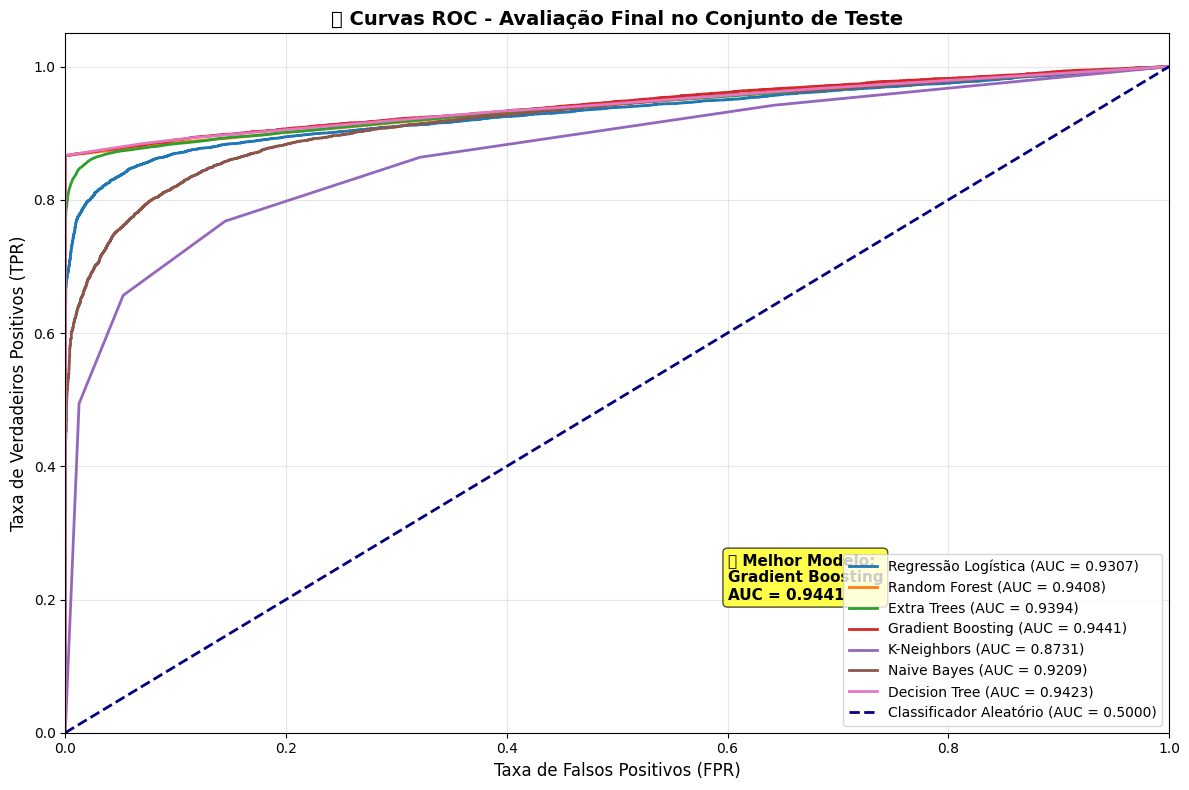


✅ PIPELINE TRIPLO FINALIZADO COM SUCESSO!
🔒 1. Dados divididos ANTES do balanceamento
⚖️ 2. Balanceamento aplicado APENAS no treino
🏋️ 3. Modelos treinados com dados balanceados
🔍 4. Validação para seleção do melhor modelo
🧪 5. Teste final para métricas imparciais

🏆 RESULTADO FINAL:
  Modelo selecionado: Gradient Boosting
  AUC na Validação: 0.9476
  AUC no Teste Final: 0.9441
  Dataset de teste: 20,000 amostras (distribuição original)
  Diferença Val-Test: 0.0035
  ✅ Modelo estável - baixo overfitting

🎯 Confiabilidade: ✅ Alta (sem vazamento de dados)


In [13]:
# ===== 5. VISUALIZAÇÃO DAS CURVAS ROC - CONJUNTO DE TESTE =====

print("📈 VISUALIZAÇÃO DAS CURVAS ROC - CONJUNTO DE TESTE")
print("=" * 50)

plt.figure(figsize=(12, 8))

# Plotar curvas ROC para cada modelo (apenas teste)
for name, (fpr, tpr, roc_auc) in roc_test.items():
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

# Linha de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Classificador Aleatório (AUC = 0.5000)')

# Configurações do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
plt.title('🧪 Curvas ROC - Avaliação Final no Conjunto de Teste', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# Destacar o melhor modelo
plt.text(0.6, 0.2, f'🏆 Melhor Modelo:\n{best_model_val}\nAUC = {final_test_auc}',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
         fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ PIPELINE TRIPLO FINALIZADO COM SUCESSO!")
print("=" * 45)
print("🔒 1. Dados divididos ANTES do balanceamento")
print("⚖️ 2. Balanceamento aplicado APENAS no treino")
print("🏋️ 3. Modelos treinados com dados balanceados")
print("🔍 4. Validação para seleção do melhor modelo")
print("🧪 5. Teste final para métricas imparciais")

print(f"\n🏆 RESULTADO FINAL:")
print(f"  Modelo selecionado: {best_model_val}")
print(f"  AUC na Validação: {best_auc_val}")
print(f"  AUC no Teste Final: {final_test_auc}")
print(f"  Dataset de teste: {len(X_test):,} amostras (distribuição original)")
print(f"  Diferença Val-Test: {float(best_auc_val) - float(final_test_auc):.4f}")

if abs(float(best_auc_val) - float(final_test_auc)) < 0.02:
    print("  ✅ Modelo estável - baixo overfitting")
else:
    print("  ⚠️  Possível overfitting - diferença significativa")

print(f"\n🎯 Confiabilidade: ✅ Alta (sem vazamento de dados)")